# Sentiment-app model
This notebook is used to train the LSTM model for the sentiment app.

## Load Data

In [3]:
import urllib.request
import sys
import zipfile
import pandas as pd
from bs4 import BeautifulSoup
import nltk
#from nltk.corpus import  stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from os import path
import numpy as np


import warnings
warnings.filterwarnings("ignore")

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/wordnet')
except:
    nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

In [4]:
# load dataset
df = pd.read_csv("dataset.csv", header=0)
df.drop_duplicates(inplace = True)
print(df.head())


                                             comment  scale
0  Takže neexistuje žiadny spôsob, ako ho zapojiť...      0
1                  Dobrý prípad, skvelá hodnota.          1
2                      Skvelé pre čeľustnú kosť.          1
3  Naviazané na nabíjačku pre rozhovory trvajúce ...      0
4                            Mikrofón je skvelý.          1


In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine
# has been programmed to ignore, both when indexing entries for searching and when retrieving them 
# as the result of a search query.
stop = set(stopwords.words("slovak"))


def remove_stopwords(s):
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('slovak')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RadarLab\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [6]:
df['comment'] = df.comment.map(remove_stopwords)

In [7]:
df.scale.value_counts()

1    1472
0    1468
Name: scale, dtype: int64

In [8]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM,Flatten,MaxPooling1D,Conv1D,Bidirectional

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import  categorical_crossentropy
from tensorflow.keras.optimizers import Adam

#set random seed for the session and also for tensorflow that runs in background for keras
import random
tf.random.set_seed(0)
random.seed(0)

In [9]:
from sklearn.model_selection import train_test_split
X = df.comment
y = df.scale
y = to_categorical(y) #one hot encode y

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

del X_train_val, y_train_val;

In [10]:
unique_words = set(np.hstack(X_train))
print(f'Unique words : {len(unique_words)}')

Unique words : 1750


Mean length: 
47.57 +- 33.57 words


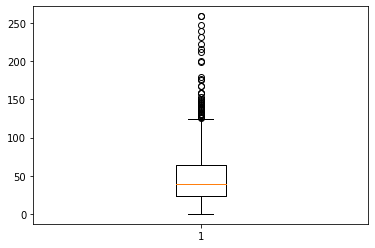

In [11]:
import matplotlib.pyplot as plt
# Summarize review length
print("Mean length: ")
result = [len(x) for x in X_train]
print(f'{np.mean(result):.2f} +- {np.std(result):.2f} words')
# plot review length
plt.boxplot(result)
plt.show();

max length: 259


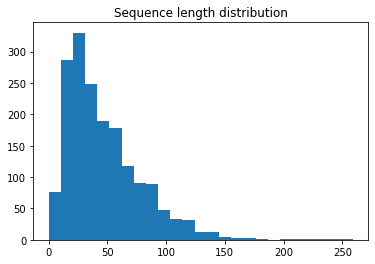

In [12]:
MAX_LENGTH = max(map(len, X_train))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, X_train)), bins=25);

In [11]:
tokenizer = Tokenizer(num_words=len(list(unique_words)),oov_token='#')
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(list(X_train))
X_val = tokenizer.texts_to_sequences(list(X_val))
X_test = tokenizer.texts_to_sequences(list(X_test))

X_train = sequence.pad_sequences(X_train, maxlen=MAX_LENGTH)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LENGTH)

print(X_train.shape,X_val.shape,X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1764, 259) (588, 259) (588, 259)
(1764, 2) (588, 2) (588, 2)


In [1]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 10)
callback = [early_stopping]

NameError: name 'EarlyStopping' is not defined

In [2]:
## Model  Bidirectional LSTM
num_classes = 2
model_1=Sequential()
model_1.add(Embedding(len(list(unique_words)),64,input_length=MAX_LENGTH))
model_1.add(Bidirectional(LSTM(64,dropout=0.3, recurrent_dropout=0.3,return_sequences=True)))
model_1.add(Dropout(0.3))
model_1.add(Bidirectional(LSTM(64,dropout=0.5, recurrent_dropout=0.3,return_sequences=False)))
model_1.add(Dropout(0.3))
model_1.add(Dense(32,activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(num_classes,activation='softmax'))
model_1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model_1.summary()

NameError: name 'Sequential' is not defined

In [14]:
history=model_1.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=1000, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/6
7/7 [==============================] - 42s 5s/step - loss: 0.6951 - accuracy: 0.5006 - val_loss: 0.6983 - val_accuracy: 0.4762
Epoch 2/6
7/7 [==============================] - 37s 5s/step - loss: 0.6814 - accuracy: 0.5856 - val_loss: 0.6444 - val_accuracy: 0.7041
Epoch 3/6
7/7 [==============================] - 40s 6s/step - loss: 0.5192 - accuracy: 0.7755 - val_loss: 0.5167 - val_accuracy: 0.7364
Epoch 4/6
7/7 [==============================] - 41s 6s/step - loss: 0.2545 - accuracy: 0.9019 - val_loss: 0.6949 - val_accuracy: 0.7415
Epoch 5/6
7/7 [==============================] - 43s 6s/step - loss: 0.1646 - accuracy: 0.9388 - val_loss: 0.6763 - val_accuracy: 0.7551
Epoch 6/6
7/7 [==============================] - 44s 6s/step - loss: 0.1115 - accuracy: 0.9620 - val_loss: 0.8319 - val_accuracy: 0.7568


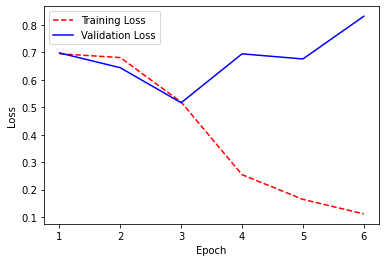

Accuracy: 70.75%


In [15]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
scores = model_1.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [16]:
import pickle
with open('data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
from tensorflow.keras.models import model_from_json
# serialize model to JSON
model_json = model_1.to_json()
with open("data/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_1.save_weights("data/model.h5")
print("Saved model to disk")

Saved model to disk


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing import sequence
import numpy as np
import pickle

with open('data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
print("Loading saved tokenizer...")

# load json and create model
json_file = open('data/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("data/model.h5")
print("Loading saved model...")

def predict_response(response):
    '''
    0 - negative
    1 - positive
    '''
    print(f'You said: \n{response}\n')
    response = tokenizer.texts_to_sequences(response)
    response = sequence.pad_sequences(response, maxlen=259)
    pred = np.argmax(model.predict(response))
    if pred == 0:
        return 'Negative'
    elif pred == 1:
        return 'Positive'
     

Loading saved tokenizer...
Loading saved model...


In [33]:
user_input = input()
response = predict_response(response=[user_input])
print(response)

Pripojil som bluetooth mojej manželky (Motorola HS85 ) k telefónu a fungovalo to ako kúzlo, či už som mal telefón vo vrecku alebo v puzdre.    
You said: 
['Pripojil som bluetooth mojej manželky (Motorola HS85 ) k telefónu a fungovalo to ako kúzlo, či už som mal telefón vo vrecku alebo v puzdre.    ']

Positive
